### Load data

In [1]:
# Install and load the required package if not already installed
if (!requireNamespace("readr", quietly = TRUE)) {
  install.packages("readr")
}
library(readr)

# Define the file paths for all CSV files
file_paths <- c("trips_import_2019-06.csv", "trips_import_2019-05.csv")

# Initialize an empty dataframe
trips <- data.frame()

# Loop through each file, read it, and append to the trips dataframe
for (file_path in file_paths) {
  temp_df <- read_csv(file_path)
  trips <- rbind(trips, temp_df)
}

# View the first few rows of the combined dataframe
head(trips)


Rows: 5463582 Columns: 23
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): pickup_weekday
dbl (22): passenger_count, trip_distance, RatecodeID, extra, tip_amount, tot...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 5959386 Columns: 23
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): pickup_weekday
dbl (22): passenger_count, trip_distance, RatecodeID, extra, tip_amount, tot...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


passenger_count,trip_distance,RatecodeID,extra,tip_amount,total_amount,pickuptime_in_seconds,trip_duration,pickup_weekday,PULocationID_encoded,⋯,pickup_is_weekend,trip_log_duration,trip_log_distance,trip_duration_squared,trip_distance_squared,duration_log_interaction,duration_distance_squared_interaction,trip_duration_cubed,trip_distance_cubed,duration_distance_cubed_interaction
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.0,1,0.5,0.00,4.3,3313,64,Saturday,23.42940,⋯,1,4.174387,0.0000000,4096,0.00,0.000000,0,262144,0.000,0
1,0.0,1,3.0,0.00,6.3,391,21,Saturday,14.72242,⋯,1,3.091042,0.0000000,441,0.00,0.000000,0,9261,0.000,0
1,4.4,1,0.5,0.00,18.8,1025,1173,Saturday,13.42714,⋯,1,7.068172,1.6863990,1375929,19.36,31.099957,26637985,1613964717,85.184,137483970453
0,0.8,1,1.0,0.00,4.3,3542,10,Saturday,23.42940,⋯,1,2.397895,0.5877867,100,0.64,1.918316,64,1000,0.512,512
1,1.7,1,3.0,2.65,13.3,205,737,Saturday,14.72766,⋯,1,6.603944,0.9932518,543169,2.89,11.226705,1569758,400315553,4.913,1966750312
2,1.6,1,3.0,1.00,13.3,1711,652,Saturday,15.09961,⋯,1,6.481577,0.9555114,425104,2.56,10.370523,1088266,277167808,4.096,1135279342


### Draw correlation heatmap

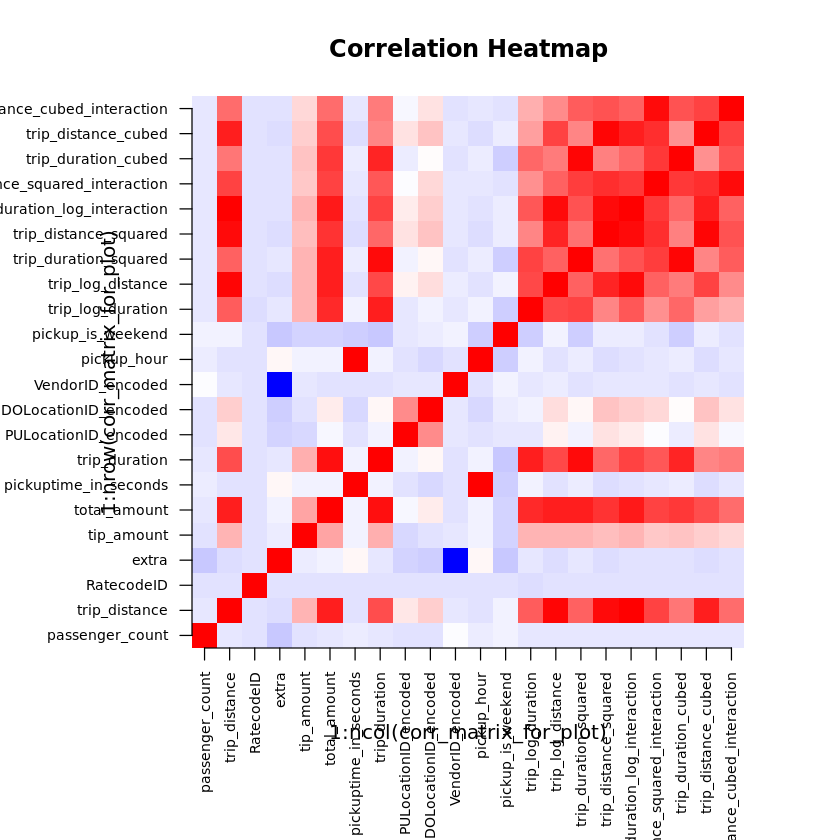

In [2]:
# Step 1: Identify numeric columns
numeric_cols <- trips[, sapply(trips, is.numeric)]

# Step 2: Calculate the correlation matrix
corr_matrix <- cor(numeric_cols)

# Step 3: Reshape the correlation matrix manually (melt) without using additional libraries
corr_matrix_melt <- data.frame(
  Var1 = rep(rownames(corr_matrix), each = ncol(corr_matrix)),
  Var2 = rep(colnames(corr_matrix), times = nrow(corr_matrix)),
  value = as.vector(corr_matrix)
)

# Step 4: Create the heatmap using base R's image() function
# Reshape the correlation matrix into a matrix for plotting
corr_matrix_for_plot <- as.matrix(corr_matrix)

# Define color palette for heatmap
color_palette <- colorRampPalette(c("blue", "white", "red"))(100)

# Set up the plot layout to have extra space for axis labels
par(mar = c(8, 8, 4, 4))  # Increase the margins to fit the labels outside the plot

# Plot the heatmap
image(1:ncol(corr_matrix_for_plot), 1:nrow(corr_matrix_for_plot), corr_matrix_for_plot, 
      col = color_palette, axes = FALSE, main = "Correlation Heatmap")

# Add axis labels  with adjusted positions
# Horizontal axis
axis(1, at = 1:ncol(corr_matrix_for_plot), labels = colnames(corr_matrix_for_plot), las = 2, cex.axis = 0.7)
# Vertical axis 
axis(2, at = 1:nrow(corr_matrix_for_plot), labels = rownames(corr_matrix_for_plot), las = 2, cex.axis = 0.7)


Apart from polinomial variables there are other highly correlated variables such as pickup_hour (with total amount), trip duration (with total amount), trip_distance. <br>

In [3]:
# Create the pickup_is_weekend column based on pickup_weekday
trips$pickup_is_weekend <- ifelse(trips$pickup_weekday %in% c("Saturday", "Sunday"), 1, 0)

# Now create the interaction column
trips$pickuptime_weekend_interaction <- trips$pickup_is_weekend * trips$pickuptime_in_seconds

trips$log_total_amount <- log(trips$total_amount)

In [4]:
# Set the seed for reproducibility
set.seed(123)

# Get the indices of the dataset
dt_index <- 1:nrow(trips)

# Sample 80% of the indices
smpl_index <- sample(dt_index, size = floor(0.8 * length(dt_index)), replace = FALSE)

# Create the training set using the sampled indices
dt_train <- trips[smpl_index, ]

# Create the test set by excluding the sampled indices
dt_test <- trips[-smpl_index, ]

# Reset the index for the training set (reset row names in R)
rownames(dt_train) <- NULL

# Print the lengths of the datasets
cat("Length of training set:", nrow(dt_train), "\n")
cat("Length of test set:", nrow(dt_test), "\n")


Length of training set: 9138374 
Length of test set: 2284594 


In [5]:
# Get all column names from the 'trips' dataframe
column_names <- names(dt_train)

# Print the column names
print(column_names)

 [1] "passenger_count"                      
 [2] "trip_distance"                        
 [3] "RatecodeID"                           
 [4] "extra"                                
 [5] "tip_amount"                           
 [6] "total_amount"                         
 [7] "pickuptime_in_seconds"                
 [8] "trip_duration"                        
 [9] "pickup_weekday"                       
[10] "PULocationID_encoded"                 
[11] "DOLocationID_encoded"                 
[12] "VendorID_encoded"                     
[13] "pickup_hour"                          
[14] "pickup_is_weekend"                    
[15] "trip_log_duration"                    
[16] "trip_log_distance"                    
[17] "trip_duration_squared"                
[18] "trip_distance_squared"                
[19] "duration_log_interaction"             
[20] "duration_distance_squared_interaction"
[21] "trip_duration_cubed"                  
[22] "trip_distance_cubed"                  
[23] "dura

Variables included: <br>
- RatecodeID
- pickuptime_weekend_interaction - i think pickup time should play significant role here. Added interaction on weekends because it is expected to have a higher price on weekends
- trip_log_duration, trip_duration_cubed - polinomial terms form trip_duration because trip_duration is highly correlated with total_amount but should be significant for predictions. After trying various combinations, these two combined work better.
- PU/DU locations
- VendorID <br>
<br>
Differently from 2020 regression, here I excluded trip_log_distance due to high VIF's

In [8]:
# Define Independent variables
column_names <- c( "RatecodeID", 
                  "pickuptime_weekend_interaction",
                  "DOLocationID_encoded", "VendorID_encoded", "PULocationID_encoded",
                  "trip_log_duration", 
                  "trip_duration_squared", 
                  "trip_distance_squared")

# Define the dependent variable (target)
dependent_variable <- "log_total_amount"


# Step 3: Create the formula for the linear regression
formula <- as.formula(paste(dependent_variable, "~", paste(column_names[column_names != dependent_variable], collapse = " + ")))

# Step 4: Fit the linear regression model
model <- lm(formula, data = dt_train)

# Step 5: View the summary of the model
print(summary(model))




Call:
lm(formula = formula, data = dt_train)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.83895 -0.04011  0.01226  0.05163  2.85800 

Coefficients:
                                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)                     7.777e-01  2.528e-03  307.60   <2e-16 ***
RatecodeID                      8.094e-03  6.710e-05  120.63   <2e-16 ***
pickuptime_weekend_interaction -2.400e-07  1.366e-09 -175.72   <2e-16 ***
DOLocationID_encoded           -5.392e-03  1.205e-05 -447.56   <2e-16 ***
VendorID_encoded               -4.767e-03  1.429e-04  -33.36   <2e-16 ***
PULocationID_encoded            1.905e-04  1.205e-05   15.82   <2e-16 ***
trip_log_duration               2.794e-01  7.369e-05 3791.46   <2e-16 ***
trip_duration_squared           7.999e-08  6.926e-11 1154.87   <2e-16 ***
trip_distance_squared           1.609e-02  6.626e-06 2427.83   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.

### Calculate VIF's

In [7]:
calculate_vif <- function(model) {
  # Get the model matrix (X)
  X <- model.matrix(model)
  
  # Initialize a vector to store the VIFs
  vif_values <- numeric(ncol(X) - 1)  # Exclude intercept column
  
  for (i in 2:ncol(X)) {  
    temp_model <- lm(X[, i] ~ X[, -i])
    r_squared <- summary(temp_model)$r.squared  # Extract the R-squared value
    vif_values[i - 1] <- 1 / (1 - r_squared) # Calculate the VIF for this variable
  }
  
  # Return a data frame with VIF values
  vif_data <- data.frame(Variable = colnames(X)[-1], VIF = vif_values)  # Exclude intercept
  return(vif_data)
}

vif_results <- calculate_vif(model)
print(vif_results)


                        Variable      VIF
1                     RatecodeID 1.000698
2 pickuptime_weekend_interaction 1.008641
3           DOLocationID_encoded 1.451255
4               VendorID_encoded 1.002205
5           PULocationID_encoded 1.357870
6              trip_log_duration 2.358673
7          trip_duration_squared 2.650677
8          trip_distance_squared 1.778374


### Predict on fitted model and visualize

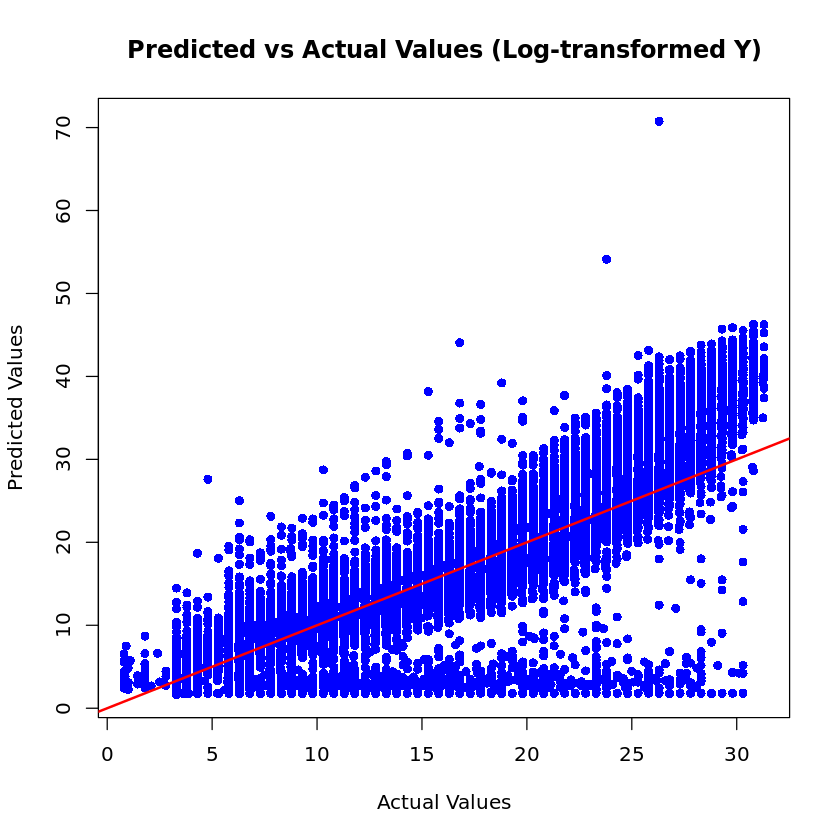

In [9]:
predictions_log <- predict(model, newdata = dt_test)

# Adjust predictions to the original scale by applying exp (since the log was taken)
predictions <- exp(predictions_log)
actual_values <- dt_test$total_amount

# Plot the predicted vs actual values
plot(actual_values, predictions,
     main = "Predicted vs Actual Values (Log-transformed Y)",
     xlab = "Actual Values",
     ylab = "Predicted Values",
     col = "blue",
     pch = 16)
abline(0, 1, col = "red", lwd = 2) 


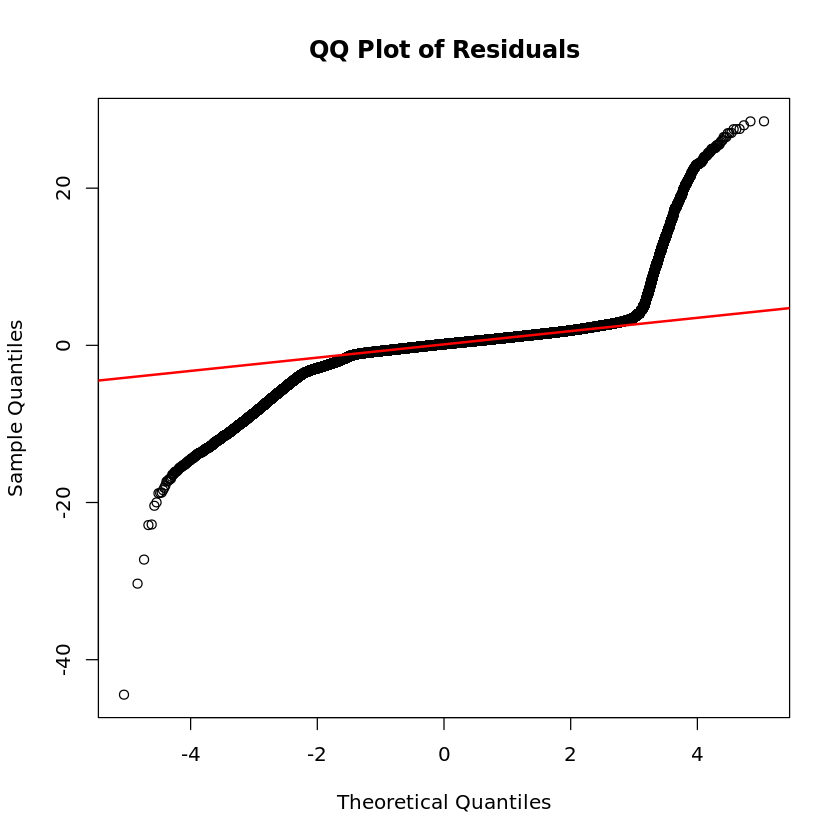

In [10]:
# Step 1: Make predictions on the test set
predictions_log <- predict(model, newdata = dt_test)

# Step 2: Convert predictions back to the original scale
predictions <- exp(predictions_log)

# Step 3: Calculate residuals (actual - predicted)
actual_values <- dt_test$total_amount
residuals <- actual_values - predictions

# Step 4: Create a QQ plot for the residuals
qqnorm(residuals, 
       main = "QQ Plot of Residuals", 
       xlab = "Theoretical Quantiles", 
       ylab = "Sample Quantiles")
qqline(residuals, col = "red", lwd = 2)  # Add a reference line


Bootstrap does not work on 2019 data - Kernel restarts everytime

In [ ]:
# Define bootstrap function for linear regression
bootstrap_validation <- function(data, formula, n_iter = 1000) {
  # Store results of bootstrap iterations
  bootstrap_results <- data.frame(R_squared = numeric(n_iter), 
                                  MSE = numeric(n_iter), 
                                  RMSE = numeric(n_iter))
  
  # Set seed for reproducibility
  set.seed(123)
  
  for (i in 1:n_iter) {
    # Create a bootstrap sample (resample with replacement)
    bootstrap_sample <- data[sample(nrow(data), replace = TRUE), ]
    
    # Fit the linear model to the bootstrap sample
    model_bootstrap <- lm(formula, data = bootstrap_sample)
    
    # Make predictions on the original data (or the out-of-bag sample)
    predictions <- predict(model_bootstrap, newdata = data)
    
    # Calculate R-squared, MSE, and RMSE for this iteration
    actual_values <- data[[dependent_variable]]
    
    # Calculate R-squared
    rsq <- summary(model_bootstrap)$r.squared
    
    # Calculate MSE
    mse <- mean((actual_values - predictions)^2)
    
    # Calculate RMSE
    rmse <- sqrt(mse)
    
    # Store the results
    bootstrap_results$R_squared[i] <- rsq
    bootstrap_results$MSE[i] <- mse
    bootstrap_results$RMSE[i] <- rmse
  }
  
  return(bootstrap_results)
}

# Call the function and perform bootstrap validation
bootstrap_results <- bootstrap_validation(dt_train, formula, n_iter = 1000)

# Calculate summary statistics (mean and confidence intervals)
mean_rsq <- mean(bootstrap_results$R_squared)
mean_mse <- mean(bootstrap_results$MSE)
mean_rmse <- mean(bootstrap_results$RMSE)

# Confidence intervals (2.5th and 97.5th percentiles)
ci_rsq <- quantile(bootstrap_results$R_squared, c(0.025, 0.975))
ci_mse <- quantile(bootstrap_results$MSE, c(0.025, 0.975))
ci_rmse <- quantile(bootstrap_results$RMSE, c(0.025, 0.975))

# Print the results
cat("Mean R-squared:", mean_rsq, "\n")
cat("R-squared 95% CI:", ci_rsq, "\n")
cat("Mean MSE:", mean_mse, "\n")
cat("MSE 95% CI:", ci_mse, "\n")
cat("Mean RMSE:", mean_rmse, "\n")
cat("RMSE 95% CI:", ci_rmse, "\n")


### Rezultatai:
- Koeficientai: Visi koeficientai yra statistiškai reikšmingi (p <0.05). Koeficientai (Estimate) yra gana maži, tačiau jie yra labai reikšmingi pagal t-values, ypač trip_log_duration, trip_duration_squared, ir trip_distance_squared, kurie turi dideles reikšmes. Tai gali reikšti, kad modelis gerai prognozuoja, tačiau labiau realu, kad kai kurios reikšmės yra nepakankamai įvertintos dėl labai didelio koreliacijos su kaina (Y).
- Modelis: R-squared: 0.9081, tai gana aukštas rodiklis, rodantis, kad modelis paaiškina 90.81% duomenų kaitos. Tai galimai rodo modelio per didelį paprastumą (overfitting)
- Multikolinearumas: VIF maži - kintamieji tarpusavyje nekoreliuoja. Iš to galime tikėtis patikimų rezultatų.
- Validavimas: Nėra atliktas bootstrap validavimas, nes nulūždavo programa, todėl tikras modelio patikimumas gali būti nepakankamai įvertintas.
- F-statistika yra labai reikšminga (p < 2.2e-16), tačiau vėl panašu į overtfitting
- Residual standard error (0.1027) rodo, kad prognozės yra gana tikslios
<BR>
<br>
2019 modelis prastesnis už 2020. Priežastis - 2019 buvo daugiau duomenų, tad galimai nebuvo apimti visi reikšmingi kintamieji bei atsirado naujų svarbių koreliacijų.